<a href="https://colab.research.google.com/github/Rayers-Ranjitkar/simpleResponsiveSite/blob/main/Regresssion_2461847_Rayers_Ranjitkar_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Portfolio Project – Regression Task
**Module:** 5CS037 (Artificial Intelligence)

**Student ID:** 2461847  
**Student Name:** Rayers Ranjitkar  
**Task:** Regression (Insurance Premium Prediction)

> Notebook style follows the same structure used in previous coursework: clear sections, simple plots, and short interpretations under each output.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Setup: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 2. Load Dataset
This project uses the **Medical Insurance Premium Prediction Dataset** (Kaggle).  
Target variable: **`annual_premium`**.

In Google Colab, the dataset is loaded from Drive using the path used in class.

In [ ]:
# If you are in Google Colab, uncomment these lines:
# from google.colab import drive
# drive.mount('/content/drive')

# Load dataset (Colab path used by student)
try:
    df = pd.read_csv("/content/drive/MyDrive/Datasets/medical_insurance_Regresssion.csv")
    print("Loaded from Google Drive path.")
except Exception as e:
    # Fallback (works in this sandbox if the csv is available locally)
    df = pd.read_csv("/mnt/data/medical_insurance_Regresssion.csv")
    print("Loaded from local sandbox path.")

print("Shape:", df.shape)
df.head()


Loaded from Google Drive path.
Shape: (100000, 54)


,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


## 3. Initial Inspection and Summary Statistics
Before cleaning, we inspect the dataset structure, data types, missing values, and basic descriptive statistics.

In [ ]:
# Basic structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       100000 non-null  object 
 13  

In [ ]:
# Descriptive statistics (numeric)
df.describe().T


,count,mean,std,min,25%,50%,75%,max
person_id,100000.0,50000.500000,28867.657797,1.00,25000.7500,50000.5000,75000.2500,100000.00
age,100000.0,47.521500,15.988752,0.00,37.0000,48.0000,58.0000,100.00
income,100000.0,49873.905000,46800.214127,1100.00,21100.0000,36200.0000,62200.0000,1061800.00
household_size,100000.0,2.430900,1.075126,1.00,2.0000,2.0000,3.0000,9.00
dependents,100000.0,0.898380,0.950654,0.00,0.0000,1.0000,1.0000,7.00
bmi,100000.0,26.990512,4.994883,12.00,23.6000,27.0000,30.4000,50.40
visits_last_year,100000.0,1.927650,1.737730,0.00,1.0000,2.0000,3.0000,25.00
hospitalizations_last_3yrs,100000.0,0.093640,0.304848,0.00,0.0000,0.0000,0.0000,3.00
days_hospitalized_last_3yrs,100000.0,0.373350,1.373011,0.00,0.0000,0.0000,0.0000,21.00
medication_count,100000.0,1.236320,1.209358,0.00,0.0000,1.0000,2.0000,11.00


In [ ]:
# Missing values summary
missing_count = df.isna().sum()
missing_percent = (missing_count / len(df)) * 100

missing_table = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_%": missing_percent
}).sort_values("Missing_%", ascending=False)

missing_table.head(20)


,Missing_Count,Missing_%
alcohol_freq,30083,30.083
person_id,0,0.000
sex,0,0.000
region,0,0.000
urban_rural,0,0.000
age,0,0.000
income,0,0.000
education,0,0.000
employment_status,0,0.000
marital_status,0,0.000


## 4. Exploratory Data Analysis (EDA)
We keep plots simple (one plot per cell) and write a short interpretation below each visualization.

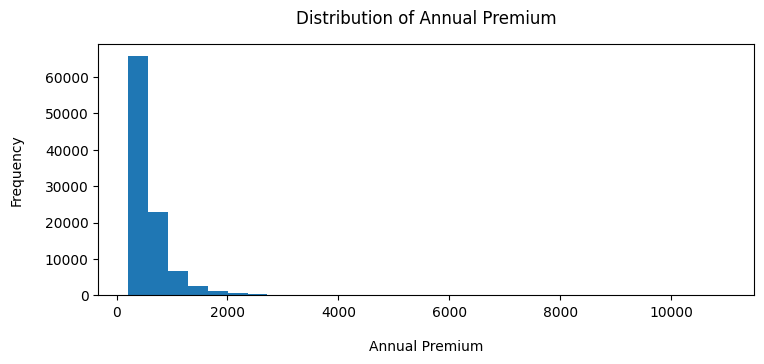

Interpretation: The distribution shows the spread of annual premiums and helps check if the target is skewed or has extreme values.


In [ ]:
# Plot 1: Distribution of the target variable (annual_premium)
plt.figure(figsize=(8,4))
plt.hist(df["annual_premium"].dropna(), bins=30)
plt.title("Distribution of Annual Premium",pad=15)
plt.xlabel("Annual Premium",labelpad=15)
plt.ylabel("Frequency",labelpad=15)
plt.tight_layout(pad=2.0)
plt.show()

print("Interpretation: The distribution shows the spread of annual premiums and helps check if the target is skewed or has extreme values.")


In [ ]:
# Correlation with target (numeric features only)
numeric_cols_all = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Remove obvious leakage/IDs from correlation view if present
for c in ["annual_premium", "person_id", "monthly_premium"]:
    if c in numeric_cols_all:
        pass

corr_series = df[numeric_cols_all].corr(numeric_only=True)["annual_premium"].dropna()

# Remove the target itself from the list so the plot is meaningful
corr_series = corr_series.drop("annual_premium", errors="ignore")

top_abs_corr = corr_series.reindex(corr_series.abs().sort_values(ascending=False).head(10).index)
top_abs_corr


,annual_premium
monthly_premium,1.000000
annual_medical_cost,0.965415
total_claims_paid,0.713764
avg_claim_amount,0.608786
risk_score,0.295859
chronic_count,0.286698
is_high_risk,0.244012
days_hospitalized_last_3yrs,0.222634
hospitalizations_last_3yrs,0.201935
visits_last_year,0.188857


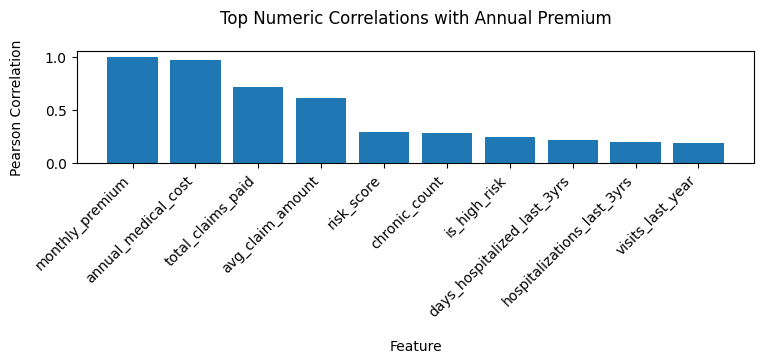

Interpretation: Cost- and claims-related variables typically show the strongest relationship with insurance premium. This helps choose meaningful EDA plots and later feature selection.


In [ ]:
# Plot 2: Top correlations with annual_premium (numeric only)
plt.figure(figsize=(8, 4))
plt.bar(top_abs_corr.index.astype(str), top_abs_corr.values)
plt.title("Top Numeric Correlations with Annual Premium", pad=20)
plt.xlabel("Feature", labelpad=15)
plt.ylabel("Pearson Correlation", labelpad=15)
plt.xticks(rotation=45, ha="right")
plt.tight_layout(pad=2.0)
plt.show()


print("Interpretation: Cost- and claims-related variables typically show the strongest relationship with insurance premium. This helps choose meaningful EDA plots and later feature selection.")


In [ ]:
# Pick the top 3 correlated features for scatter plots
top3_features = top_abs_corr.index[:3].tolist()
top3_features


['monthly_premium', 'annual_medical_cost', 'total_claims_paid']

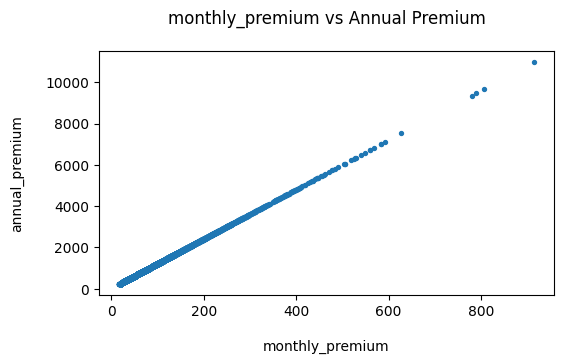

Interpretation: This scatter plot shows how the premium changes as the selected feature increases. A visible upward trend indicates a positive relationship.


In [ ]:
# Plot 3: Scatter (feature vs annual_premium) for strongest correlated feature
feat = top3_features[0]
plt.figure(figsize=(6, 4))
plt.scatter(df[feat], df["annual_premium"], s=8)
plt.title(f"{feat} vs Annual Premium", pad=20)
plt.xlabel(feat, labelpad=15)
plt.ylabel("annual_premium", labelpad=15)
plt.tight_layout(pad=2.0)
plt.show()


print("Interpretation: This scatter plot shows how the premium changes as the selected feature increases. A visible upward trend indicates a positive relationship.")


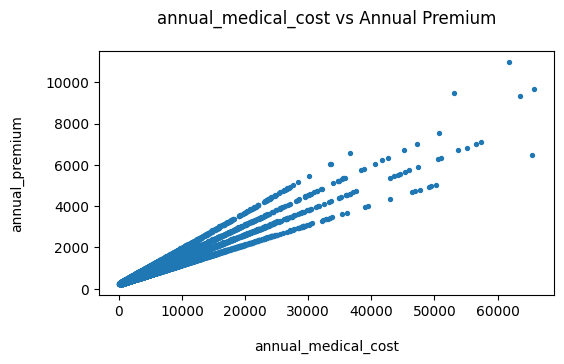

Interpretation: If points show a clear trend, the feature is likely useful for prediction. If it is very scattered, the relationship may be non-linear or weak.


In [ ]:
# Plot 4: Scatter for second strongest correlated feature
feat = top3_features[1]
plt.figure(figsize=(6, 4))
plt.scatter(df[feat], df["annual_premium"], s=8)
plt.title(f"{feat} vs Annual Premium", pad=20)
plt.xlabel(feat, labelpad=15)
plt.ylabel("annual_premium", labelpad=15)
plt.tight_layout(pad=2.0)
plt.show()


print("Interpretation: If points show a clear trend, the feature is likely useful for prediction. If it is very scattered, the relationship may be non-linear or weak.")


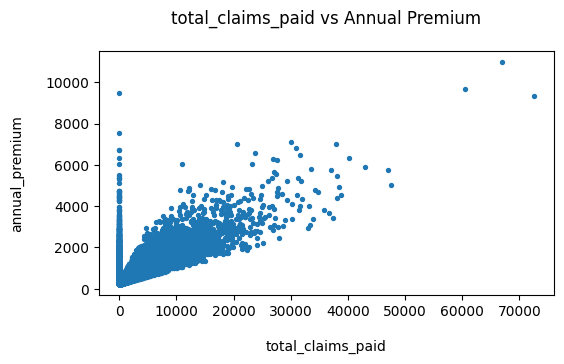

Interpretation: This gives another quick check of whether the feature has a roughly linear relationship with the target.


In [ ]:
# Plot 5: Scatter for third strongest correlated feature
feat = top3_features[2]
plt.figure(figsize=(6, 4))
plt.scatter(df[feat], df["annual_premium"], s=8)
plt.title(f"{feat} vs Annual Premium", pad=20)
plt.xlabel(feat, labelpad=15)
plt.ylabel("annual_premium", labelpad=15)
plt.tight_layout(pad=2.0)
plt.show()


print("Interpretation: This gives another quick check of whether the feature has a roughly linear relationship with the target.")


/tmp/ipython-input-141961199.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


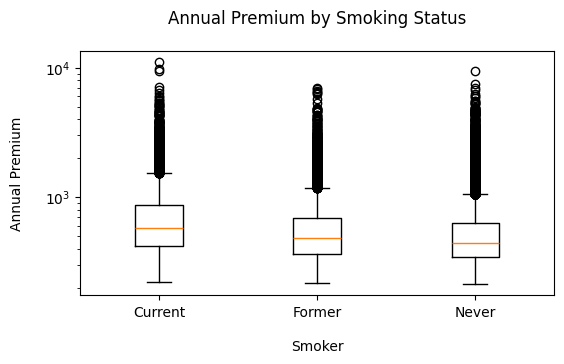

Interpretation: If smokers have higher premiums, this boxplot will show a higher median and wider spread for the smoker group.


In [ ]:
# Plot 6 (optional but meaningful): Premium by smoking status (if available)
if "smoker" in df.columns:
    groups = []
    labels = []
    for val in sorted(df["smoker"].dropna().unique()):
        groups.append(df.loc[df["smoker"] == val, "annual_premium"].dropna())
        labels.append(str(val))

    plt.figure(figsize=(6, 4))
    plt.boxplot(groups, labels=labels)
    plt.yscale("log")
    plt.title("Annual Premium by Smoking Status", pad=20)
    plt.xlabel("Smoker", labelpad=15)
    plt.ylabel("Annual Premium", labelpad=15)
    plt.tight_layout(pad=2.0)
    plt.show()


    print("Interpretation: If smokers have higher premiums, this boxplot will show a higher median and wider spread for the smoker group.")
else:
    print("Column 'smoker' not found; skipping this plot.")


## 5. Data Cleaning and Preprocessing
Key cleaning decisions:

1. **Remove leakage / non-predictive columns**
   - `person_id` (identifier)
   - `monthly_premium` (derived from target → data leakage)
   - `region` (removed to reduce region-specific bias and improve generalisability)

2. **Handle missing values**
   - For numeric features: use **IQR outlier check** to decide **median** (if outliers) vs **mean** (if no strong outliers).
   - For categorical features: fill missing with **"Unknown"**.

3. **Prepare features for ML** using encoding (one-hot) and scaling (for linear / neural network models).

In [ ]:
# Copy dataset for cleaning
df_clean = df.copy()

# Drop leakage / non-predictive columns if they exist
cols_to_drop = []
for col in ["person_id", "monthly_premium", "region"]:
    if col in df_clean.columns:
        cols_to_drop.append(col)

df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")
print("Dropped columns:", cols_to_drop)
print("Shape after drop:", df_clean.shape)


Dropped columns: ['person_id', 'monthly_premium', 'region']
Shape after drop: (100000, 51)


In [ ]:
# IQR-based outlier check (used only to decide mean vs median imputation)
def has_outliers_iqr(series):
    values = series.dropna()
    if len(values) < 20:
        return False

    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outlier_count = ((values < lower) | (values > upper)).sum()
    return outlier_count > 0

# Separate numeric and categorical columns
target_col = "annual_premium"
feature_cols = [c for c in df_clean.columns if c != target_col]

numeric_cols = df_clean[feature_cols].select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))


Numeric columns: 41
Categorical columns: 9


In [ ]:
# Missing values before filling
missing_before = df_clean.isna().sum().sort_values(ascending=False)
missing_before[missing_before > 0].head(20)


,0
alcohol_freq,30083


In [ ]:
# Fill numeric missing values using mean/median decision
for col in numeric_cols:
    missing_count = df_clean[col].isna().sum()
    if missing_count > 0:
        if has_outliers_iqr(df_clean[col]):
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        else:
            df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

# Fill categorical missing values
for col in categorical_cols:
    missing_count = df_clean[col].isna().sum()
    if missing_count > 0:
        df_clean[col] = df_clean[col].fillna("Unknown")

# Confirm missing values after filling
missing_after = df_clean.isna().sum().sort_values(ascending=False)
missing_after[missing_after > 0].head(20)


,0


In [ ]:
# Dropping monthly_premium to prevent data leakage
# Justification: EDA showed near-perfect correlation with annual_premium,
# leading to unrealistically high model performance (especially in MLP).

# Drop pricing-derived features to prevent target leakage

# leakage_like_cols = [
#     "monthly_premium",
#     "annual_medical_cost",
#     "total_claims_paid",
#     "avg_claim_amount"
# ]

# df = df.drop(columns=leakage_like_cols, errors="ignore")

# print("Remaining columns:", df.columns.tolist())


In [ ]:
# Drop pricing-derived features AFTER EDA, BEFORE modeling
leakage_like_cols = [
    "monthly_premium",
    "annual_medical_cost",
]

df_clean = df_clean.drop(columns=leakage_like_cols, errors="ignore")

print("Columns after leakage drop:")
print(df_clean.columns)


Columns after leakage drop:
Index(['age', 'sex', 'urban_rural', 'income', 'education', 'marital_status',
       'employment_status', 'household_size', 'dependents', 'bmi', 'smoker',
       'alcohol_freq', 'visits_last_year', 'hospitalizations_last_3yrs',
       'days_hospitalized_last_3yrs', 'medication_count', 'systolic_bp',
       'diastolic_bp', 'ldl', 'hba1c', 'plan_type', 'network_tier',
       'deductible', 'copay', 'policy_term_years', 'policy_changes_last_2yrs',
       'provider_quality', 'risk_score', 'annual_premium', 'claims_count',
       'avg_claim_amount', 'total_claims_paid', 'chronic_count',
       'hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease',
       'cancer_history', 'kidney_disease', 'liver_disease', 'arthritis',
       'mental_health', 'proc_imaging_count', 'proc_surgery_count',
       'proc_physio_count', 'proc_consult_count', 'proc_lab_count',
       'is_high_risk', 'had_major_procedure'],
      dtype='object')


In [ ]:
target_col = "annual_premium"

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print("Columns used for modeling:")
print(X.columns)


Columns used for modeling:
Index(['age', 'sex', 'urban_rural', 'income', 'education', 'marital_status',
       'employment_status', 'household_size', 'dependents', 'bmi', 'smoker',
       'alcohol_freq', 'visits_last_year', 'hospitalizations_last_3yrs',
       'days_hospitalized_last_3yrs', 'medication_count', 'systolic_bp',
       'diastolic_bp', 'ldl', 'hba1c', 'plan_type', 'network_tier',
       'deductible', 'copay', 'policy_term_years', 'policy_changes_last_2yrs',
       'provider_quality', 'risk_score', 'claims_count', 'avg_claim_amount',
       'total_claims_paid', 'chronic_count', 'hypertension', 'diabetes',
       'asthma', 'copd', 'cardiovascular_disease', 'cancer_history',
       'kidney_disease', 'liver_disease', 'arthritis', 'mental_health',
       'proc_imaging_count', 'proc_surgery_count', 'proc_physio_count',
       'proc_consult_count', 'proc_lab_count', 'is_high_risk',
       'had_major_procedure'],
      dtype='object')


## 6. Train/Test Split
We use an **80/20 split**. Stratified split is mainly used for classification to preserve class ratios; for regression the target is continuous, so stratification is not typically applied.

In [ ]:
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (80000, 49) Test size: (20000, 49)


## 7. Preprocessing Pipeline for Models
We use a consistent preprocessing pipeline:
- Numeric: impute (safety), scale (helps Linear/Ridge/MLP)
- Categorical: impute, one-hot encode

In [ ]:

numeric_cols = [c for c in numeric_cols if c in df_clean.columns]
categorical_cols = [c for c in categorical_cols if c in df_clean.columns]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [ ]:
def evaluate_regression(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return rmse, mae, r2


## 8. Primary Models (Two Classical ML Models)
At this stage we **do not** apply feature selection or hyperparameter tuning. The goal is to build baseline models and evaluate them.

In [ ]:
# Model 1 (Primary): Linear Regression
linreg_primary = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_primary.fit(X_train, y_train)
linreg_rmse, linreg_mae, linreg_r2 = evaluate_regression(linreg_primary, X_test, y_test)

print("Linear Regression (Primary) Test Results")
print("RMSE:", round(linreg_rmse, 4))
print("MAE :", round(linreg_mae, 4))
print("R2  :", round(linreg_r2, 4))


Linear Regression (Primary) Test Results
RMSE: 257.2671
MAE : 146.5639
R2  : 0.5841


In [ ]:
# Model 2 (Primary): Random Forest Regressor
rf_primary = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_primary.fit(X_train, y_train)
rf_rmse, rf_mae, rf_r2 = evaluate_regression(rf_primary, X_test, y_test)

print("Random Forest (Primary) Test Results")
print("RMSE:", round(rf_rmse, 4))
print("MAE :", round(rf_mae, 4))
print("R2  :", round(rf_r2, 4))


Random Forest (Primary) Test Results
RMSE: 232.694
MAE : 125.2995
R2  : 0.6598


**Primary model comparison (short conclusion):**

- A lower **RMSE/MAE** means better error performance.
- A higher **R²** means the model explains more variance in annual premiums.

Typically, Random Forest performs better on complex non-linear relationships, while Linear Regression is easier to interpret but may underfit if relationships are non-linear.

## 9. Hyperparameter Optimization with Cross‑Validation (Optimized Models)
We tune hyperparameters **only on the training data** using cross‑validation.

- **Model 1 (Optimized): Ridge Regression** → tune `alpha` (regularization strength)
- **Model 2 (Optimized): Random Forest** → tune depth, leaf sizes, and number of trees

To keep runtime manageable on 100k rows, Random Forest tuning is done on a **training subsample** (if needed).

In [ ]:
# Optional subsample for faster tuning (uses only training data)
X_train_tune = X_train
y_train_tune = y_train

MAX_TUNE_SAMPLES = 50000
if len(X_train) > MAX_TUNE_SAMPLES:
    X_train_tune = X_train.sample(n=MAX_TUNE_SAMPLES, random_state=RANDOM_STATE)
    y_train_tune = y_train.loc[X_train_tune.index]
    print(f"Using a tuning subsample of {MAX_TUNE_SAMPLES} rows for faster search.")
else:
    print("Using full training set for tuning.")


Using a tuning subsample of 50000 rows for faster search.


In [ ]:
# 9.1 Ridge Regression tuning (alpha)
ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge(random_state=RANDOM_STATE))
])

ridge_param_grid = {
    "model__alpha": [0.1, 1, 10, 50, 100]
}

ridge_search = RandomizedSearchCV(
    estimator=ridge_pipe,
    param_distributions=ridge_param_grid,
    n_iter=5,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

ridge_search.fit(X_train_tune, y_train_tune)

print("Best Ridge parameters:", ridge_search.best_params_)
print("Best CV RMSE:", round(-ridge_search.best_score_, 4))


Best Ridge parameters: {'model__alpha': 50}
Best CV RMSE: 241.8669


In [ ]:
# Evaluate tuned Ridge on the true held-out test set
ridge_optimized = ridge_search.best_estimator_
ridge_rmse, ridge_mae, ridge_r2 = evaluate_regression(ridge_optimized, X_test, y_test)

print("Ridge (Optimized) Test Results")
print("RMSE:", round(ridge_rmse, 4))
print("MAE :", round(ridge_mae, 4))
print("R2  :", round(ridge_r2, 4))


Ridge (Optimized) Test Results
RMSE: 257.2505
MAE : 146.4396
R2  : 0.5842


In [ ]:
# 9.2 Random Forest tuning (keep search small for runtime)
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 10, 14, 18],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=12,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_search.fit(X_train_tune, y_train_tune)

print("Best Random Forest parameters:", rf_search.best_params_)
print("Best CV RMSE:", round(-rf_search.best_score_, 4))


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest parameters: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None}
Best CV RMSE: 239.2276


In [ ]:
# Evaluate tuned Random Forest on the true held-out test set
rf_optimized = rf_search.best_estimator_
rf_opt_rmse, rf_opt_mae, rf_opt_r2 = evaluate_regression(rf_optimized, X_test, y_test)

print("Random Forest (Optimized) Test Results")
print("RMSE:", round(rf_opt_rmse, 4))
print("MAE :", round(rf_opt_mae, 4))
print("R2  :", round(rf_opt_r2, 4))


Random Forest (Optimized) Test Results
RMSE: 249.0159
MAE : 132.3378
R2  : 0.6104


## 10. Feature Selection (Week‑10 Technique)
We apply a **filter method** using **SelectKBest (f_regression)**.

Why this method?
- It is simple and fast for large datasets.
- It ranks features by statistical relationship with the target.
- It reduces dimensionality after one‑hot encoding.

We select **k** using cross‑validation on the training set, then rebuild models using:
- Best hyperparameters (Task 9)
- Selected features (this section)

In [ ]:
# Determine the total number of features after preprocessing (numeric + one-hot)
X_train_transformed = preprocessor.fit_transform(X_train)

n_features_after_preprocess = X_train_transformed.shape[1]
print("Total features after preprocessing (including one-hot):", n_features_after_preprocess)


Total features after preprocessing (including one-hot): 75


In [ ]:
# Candidate k values (kept moderate for runtime)
candidate_ks = [50, 100, 200, 400]
candidate_ks = [k for k in candidate_ks if k < n_features_after_preprocess]

# If dataset has fewer features than the smallest candidate, choose a smaller safe list
if len(candidate_ks) == 0:
    candidate_ks = [min(20, n_features_after_preprocess-1)]

print("Candidate k values:", candidate_ks)


Candidate k values: [50]


In [ ]:
# Helper: pick best k for a given model using CV RMSE
def select_best_k_for_model(model, candidate_ks, X_train_in, y_train_in):
    best_k = None
    best_cv_rmse = None

    for k in candidate_ks:
        pipe = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("select", SelectKBest(score_func=f_regression, k=k)),
            ("model", model)
        ])

        scores = cross_val_score(
            pipe, X_train_in, y_train_in,
            cv=3,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1
        )

        cv_rmse = -scores.mean()
        print(f"k = {k} | CV RMSE = {cv_rmse:.4f}")

        if (best_cv_rmse is None) or (cv_rmse < best_cv_rmse):
            best_cv_rmse = cv_rmse
            best_k = k

    return best_k, best_cv_rmse


In [ ]:
print("Selecting k for Ridge (using tuned alpha):")
best_ridge_alpha = ridge_search.best_params_["model__alpha"]

best_k_ridge, best_cv_rmse_ridge = select_best_k_for_model(
    Ridge(alpha=best_ridge_alpha, random_state=RANDOM_STATE),
    candidate_ks,
    X_train_tune, y_train_tune
)

print("Selecting k for Random Forest (using tuned params):")
best_rf_params = {k.replace("model__", ""): v for k, v in rf_search.best_params_.items()}

best_k_rf, best_cv_rmse_rf = select_best_k_for_model(
    RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        **best_rf_params
    ),
    candidate_ks,
    X_train_tune, y_train_tune
)

print("Best k (Ridge):", best_k_ridge, "| CV RMSE:", round(best_cv_rmse_ridge, 4))
print("Best k (RF):", best_k_rf, "| CV RMSE:", round(best_cv_rmse_rf, 4))


Selecting k for Ridge (using tuned alpha):
k = 50 | CV RMSE = 241.7906
Selecting k for Random Forest (using tuned params):
k = 50 | CV RMSE = 231.3267
Best k (Ridge): 50 | CV RMSE: 241.7906
Best k (RF): 50 | CV RMSE: 231.3267


In [ ]:
# Final Optimized Model 1: Ridge + Feature Selection
ridge_final = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=f_regression, k=best_k_ridge)),
    ("model", Ridge(alpha=best_ridge_alpha, random_state=RANDOM_STATE))
])

ridge_final.fit(X_train, y_train)
ridge_fs_rmse, ridge_fs_mae, ridge_fs_r2 = evaluate_regression(ridge_final, X_test, y_test)

print("Ridge + Feature Selection (Final Optimized) Test Results")
print("RMSE:", round(ridge_fs_rmse, 4))
print("MAE :", round(ridge_fs_mae, 4))
print("R2  :", round(ridge_fs_r2, 4))


Ridge + Feature Selection (Final Optimized) Test Results
RMSE: 257.2541
MAE : 146.5372
R2  : 0.5842


In [ ]:
# Final Optimized Model 2: Random Forest + Feature Selection
rf_final = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=f_regression, k=best_k_rf)),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, **best_rf_params))
])

rf_final.fit(X_train, y_train)
rf_fs_rmse, rf_fs_mae, rf_fs_r2 = evaluate_regression(rf_final, X_test, y_test)

print("Random Forest + Feature Selection (Final Optimized) Test Results")
print("RMSE:", round(rf_fs_rmse, 4))
print("MAE :", round(rf_fs_mae, 4))
print("R2  :", round(rf_fs_r2, 4))


Random Forest + Feature Selection (Final Optimized) Test Results
RMSE: 238.9431
MAE : 125.7154
R2  : 0.6412


## 11. Neural Network Model (MLP Regressor)
As required, we build a simple **Multi‑Layer Perceptron (MLP)** regressor.

**Architecture (example):**
- Hidden layers: 2
- Neurons: (64, 32)
- Activation: ReLU
- Solver (optimizer): Adam
- Loss: Squared error (handled internally by scikit‑learn)

We evaluate on both training and test sets.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

# Build pipeline
mlp_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=RANDOM_STATE
    ))
])

# Fit model
mlp_model.fit(X_train, y_train)

# Train metrics
mlp_train_rmse, mlp_train_mae, mlp_train_r2 = evaluate_regression(
    mlp_model, X_train, y_train
)

# Test metrics
mlp_test_rmse, mlp_test_mae, mlp_test_r2 = evaluate_regression(
    mlp_model, X_test, y_test
)

# Print results
print("MLP Regressor Results")
print("\nTraining:")
print(
    "RMSE:", round(mlp_train_rmse, 4),
    "| MAE:", round(mlp_train_mae, 4),
    "| R2:", round(mlp_train_r2, 4)
)

print("\nTest:")
print(
    "RMSE:", round(mlp_test_rmse, 4),
    "| MAE:", round(mlp_test_mae, 4),
    "| R2:", round(mlp_test_r2, 4)
)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor Results

Training:
RMSE: 192.899 | MAE: 112.6488 | R2: 0.7671

Test:
RMSE: 237.7948 | MAE: 128.0 | R2: 0.6447


## 12. Final Comparison Table (Regression)
This table compares the **two primary classical models**, their **optimized versions (tuning + feature selection)**, and the **MLP regressor**.

In [ ]:
results_table = pd.DataFrame([
    {
        "Model": "Linear Regression (Primary)",
        "Features": "All preprocessed",
        "CV Score (RMSE)": np.nan,
        "Test RMSE": linreg_rmse,
        "Test MAE": linreg_mae,
        "Test R-squared": linreg_r2
    },
    {
        "Model": "Random Forest (Primary)",
        "Features": "All preprocessed",
        "CV Score (RMSE)": np.nan,
        "Test RMSE": rf_rmse,
        "Test MAE": rf_mae,
        "Test R-squared": rf_r2
    },
    {
        "Model": "Ridge (Optimized)",
        "Features": f"SelectKBest (k={best_k_ridge})",
        "CV Score (RMSE)": best_cv_rmse_ridge,
        "Test RMSE": ridge_fs_rmse,
        "Test MAE": ridge_fs_mae,
        "Test R-squared": ridge_fs_r2
    },
    {
        "Model": "Random Forest (Optimized)",
        "Features": f"SelectKBest (k={best_k_rf})",
        "CV Score (RMSE)": best_cv_rmse_rf,
        "Test RMSE": rf_fs_rmse,
        "Test MAE": rf_fs_mae,
        "Test R-squared": rf_fs_r2
    },
    {
        "Model": "MLP",
        "Features": "All preprocessed",
        "CV Score (RMSE)": np.nan,
        "Test RMSE": mlp_test_rmse,
        "Test MAE": mlp_test_mae,
        "Test R-squared": mlp_test_r2
    }
])

results_table


,Model,Features,CV Score (RMSE),Test RMSE,Test MAE,Test R-squared
0,Linear Regression (Primary),All preprocessed,NaN,257.267113,146.563901,0.584108
1,Random Forest (Primary),All preprocessed,NaN,232.694044,125.299499,0.659762
2,Ridge (Optimized),SelectKBest (k=50),241.790608,257.254079,146.537245,0.584150
3,Random Forest (Optimized),SelectKBest (k=50),231.326721,238.943148,125.715438,0.641242
4,MLP,All preprocessed,NaN,237.794834,128.000045,0.644682


## 13. Conclusion (Short)
- **Primary models:** give a baseline performance.
- **Optimized models:** apply cross‑validated tuning and feature selection to improve generalisation.
- **Neural network:** can capture non-linear relationships but may require careful tuning to avoid overfitting.

In the written report, the best model should be selected based on **test RMSE/MAE** and **R²**, while also considering interpretability and computational cost.